In [ ]:
#Importing Libraries
import pandas as pd          
import numpy as np          # For mathematical calculations
import matplotlib.pyplot as plt  # For plotting graphs
from datetime import datetime    # To access datetime
from pandas import Series        # To work on series
import matplotlib
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")
from math import sqrt
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


#Reading Data
df = pd.read_excel('Merged_pollution_dataset - wo 2016 17.xlsx')
df_bbsr = df[(df['City/Town/Village/Area'] == 'Bhubaneswar') | (df['City/Town/Village/Area'] == 'Bhubaneshwar')]

df_bbsr.dtypes

df_bbsr['RSPM/PM10'] = pd.to_numeric(df_bbsr['RSPM/PM10'], errors='coerce')
df_bbsr['SO2'] = pd.to_numeric(df_bbsr['SO2'], errors='coerce')
df_bbsr['NO2'] = pd.to_numeric(df_bbsr['NO2'], errors='coerce')
df_bbsr['SPM'] = pd.to_numeric(df_bbsr['SPM'], errors='coerce')

df_bbsr.dtypes

#Data Preprocessing
df_bbsr['Location of Monitoring Station'].replace('SPCB Building, Bhubaneshwar', 'OSPCB Bldg',inplace=True)
df_bbsr['Location of Monitoring Station'].replace('Capital Police Station, Bhubaneshwar', 'Capital Police Stn.',inplace=True)
df_bbsr['Location of Monitoring Station'].replace('IRC Vilage, Bhubaneshwar', 'IRC',inplace=True)
df_bbsr['Location of Monitoring Station'].replace('Chandrasekharpur. Bhubneswar', 'Chandrasekharpur',inplace=True)
df_bbsr['Location of Monitoring Station'].replace('Water works, Palasuni, Bhubneswar', 'Palasuni',inplace=True)
df_bbsr['Location of Monitoring Station'].replace('Patrapada, Bhubneswar', 'Patrapada',inplace=True)

df_bbsr_cps = df_bbsr[(df_bbsr['Location of Monitoring Station'] == 'Capital Police Stn.')]

Stn Code                          401
Sampling Date                       0
State                               0
City/Town/Village/Area              0
Location of Monitoring Station      0
Agency                              0
Type of Location                    0
SO2                               389
NO2                                 3
RSPM/PM10                           0
SPM                               213
year                                0
month                               0
day                                 0
day of week                         0
weekend                             0
dtype: int64

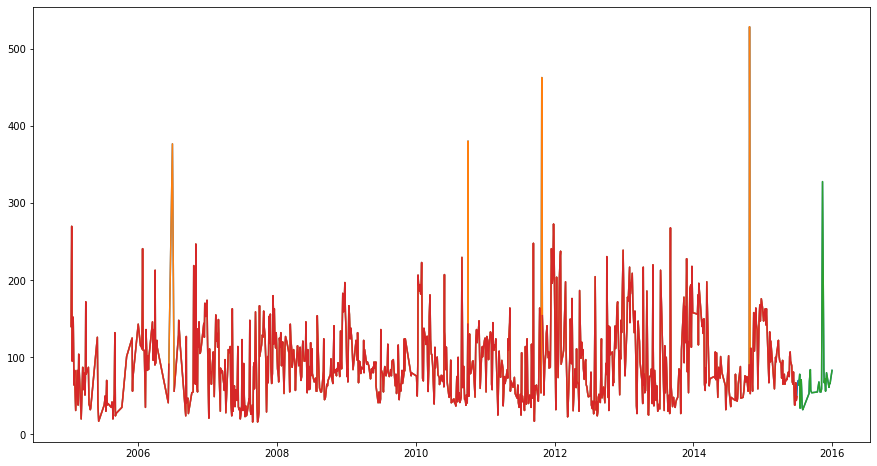

In [ ]:
df_bbsr_cps['Sampling Date'] = pd.to_datetime(df_bbsr_cps['Sampling Date'], format='%Y-%m-%d %H:%M')

#Setting default Plot Size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,8

#Index Sorting
df_bbsr_cps = df_bbsr_cps.set_index(df_bbsr_cps['Sampling Date'])
df_bbsr_cps = df_bbsr_cps.sort_index()
plt.plot(df_bbsr_cps['RSPM/PM10'])

#Separating Year, Month, Day and Day of Week
df_bbsr_cps['year'] = df_bbsr_cps['Sampling Date'].dt.year 
df_bbsr_cps['month'] = df_bbsr_cps['Sampling Date'].dt.month 
df_bbsr_cps['day'] = df_bbsr_cps['Sampling Date'].dt.day
df_bbsr_cps['day of week'] = df_bbsr_cps['Sampling Date'].dt.dayofweek

#Determining Weekend
def weekend(row):
    if (row == 5) or (row == 6):
        return 1
    else:
        return 0

df_bbsr_cps['weekend'] = df_bbsr_cps['day of week'].apply(weekend)

#Splitting into Training and Test Dataset
test_cps = df_bbsr_cps['2015-07-07':]
train_cps = df_bbsr_cps[:'2015-06']

#Visualising the Training and Test Dataset
plt.plot(train_cps['RSPM/PM10'])
plt.plot(test_cps['RSPM/PM10'])

#Outlier Removal
std_dev_cps = train_cps['RSPM/PM10'].std() #Standard Deviation of SPM

train_cps['RSPM/PM10'][train_cps['RSPM/PM10'] > (6.5*std_dev_cps)] = np.nan   #Replacing Outlier with "nan"
plt.plot(train_cps['RSPM/PM10'])
train_cps.isna().sum()

train_cps['RSPM/PM10'] = train_cps['RSPM/PM10'].fillna(method = 'backfill')   #Replacing "nan" with the previous values
train_cps.isna().sum()

In [ ]:
print(train_cps.shape)
print(test_cps.shape)
print(test_cps['RSPM/PM10'].T)

(909, 16)
(28, 16)
Sampling Date
2015-07-09     64.0
2015-07-14     78.0
2015-07-16     34.0
2015-07-22     71.0
2015-07-24     59.0
2015-07-27     35.0
2015-07-30     32.0
2015-09-01     53.0
2015-09-03     69.0
2015-09-08     84.0
2015-09-10     57.0
2015-09-15     54.0
2015-10-15     55.0
2015-10-23     68.0
2015-10-29     55.0
2015-11-03     55.0
2015-11-06     59.0
2015-11-11    328.0
2015-11-18     85.0
2015-11-20     67.0
2015-11-23     72.0
2015-11-27     56.0
2015-12-02     80.0
2015-12-15     61.0
2015-12-18     66.0
2015-12-21     66.0
2015-12-23     70.0
2015-12-31     83.0
Name: RSPM/PM10, dtype: float64


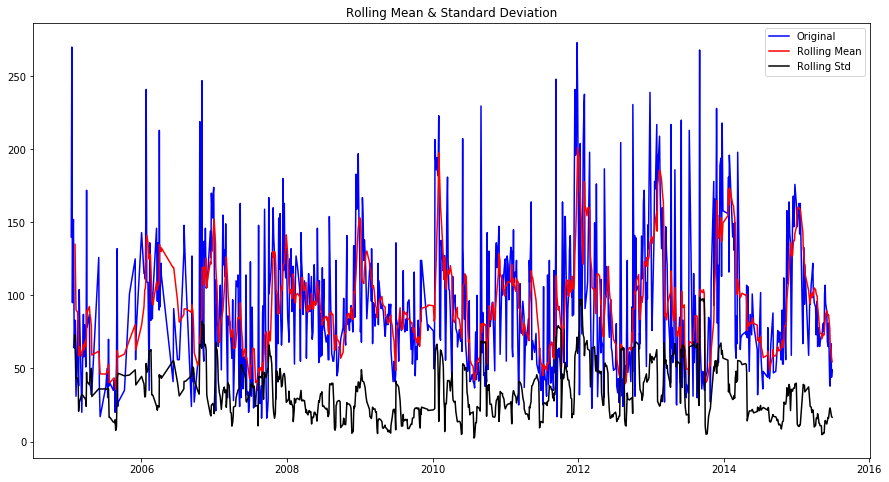

Results of Dickey-Fuller Test:
Test Statistic         -5.879419e+00
p-value                 3.103665e-07
#Lags Used              2.100000e+01
No. of Obs. Used        8.870000e+02
Critical Value (1%)    -3.437744e+00
Critical Value (5%)    -2.864804e+00
Critical Value (10%)   -2.568508e+00
dtype: float64


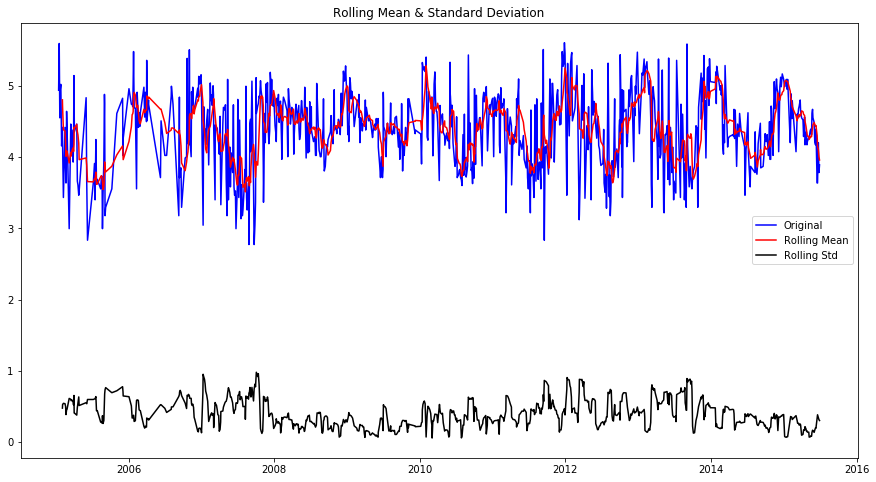

Results of Dickey-Fuller Test:
Test Statistic           -5.045804
p-value                   0.000018
#Lags Used                9.000000
No. of Obs. Used        899.000000
Critical Value (1%)      -3.437645
Critical Value (5%)      -2.864760
Critical Value (10%)     -2.568485
dtype: float64


In [ ]:
test_cps_log = pd.DataFrame(np.log(test_cps['RSPM/PM10']), index = test_cps.index, 
                               columns = ['RSPM/PM10'])

train_cps_log = np.log(train_cps['RSPM/PM10'])

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
        
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','No. of Obs. Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(train_cps['RSPM/PM10'])
test_stationarity(train_cps_log)


In [ ]:
!pip install pyramid-arima

     |████████████████████████████████| 604kB 5.1MB/s 


In [ ]:
!pip install fbprophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


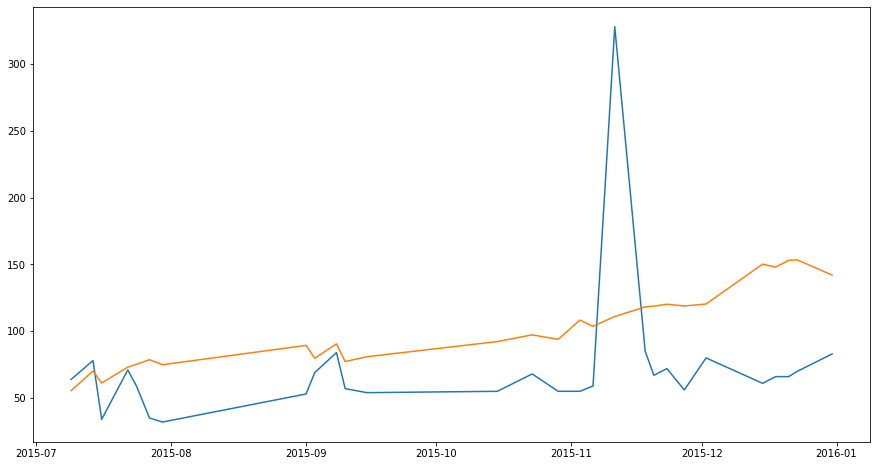

In [ ]:
#'''PROPHET GENERAL MODEL'''
from fbprophet import Prophet
pro_train = pd.DataFrame(index = range(0,len(train_cps)))
pro_train['ds'] = train_cps.index
pro_train['y'] = train_cps['RSPM/PM10'].values

prop = Prophet(weekly_seasonality = True)
prop.fit(pro_train)
future = prop.make_future_dataframe(periods = 500)
forecast = prop.predict(future)

forecast = forecast.set_index(forecast['ds'])
# forecast = forecast['2015']
forecast = forecast['2015-07-07':]
# forecast = forecast.resample('W').mean()
# forecast = forecast[1:]
test_cps['pred_RSPM'] = forecast['yhat']
# test_cps['pred SPM upper'] = forecast['yhat_upper']
# test_cps['pred SPM lower'] = forecast['yhat_lower']

plt.plot(test_cps.index,test_cps['RSPM/PM10'])
plt.plot(test_cps.index, test_cps['pred_RSPM'])

In [ ]:
# from sklearn.metrics import mean_squared_error
# from math import sqrt

# rms = sqrt(mean_squared_error(y_test, yhat))
# print(rms)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
def mean_absolute_percentage_error(y_true, y_pred): 
    # y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


rms = sqrt(mean_squared_error(test_cps['RSPM/PM10'], test_cps['pred_RSPM']))
print(rms)

mse = mean_squared_error(test_cps['RSPM/PM10'], test_cps['pred_RSPM'])
print(mse)

mae = mean_absolute_error(test_cps['RSPM/PM10'], test_cps['pred_RSPM'])
print(mae)

mape = mean_absolute_percentage_error(test_cps['RSPM/PM10'], test_cps['pred_RSPM'])
print(mape)

61.984879700509495
3842.1253114866345
46.66711629124004
68.89015720613276


In [ ]:
 test_cps['SPM']

Sampling Date
2015-09-01    14.0
2015-09-03    19.0
2015-09-08    17.0
2015-09-10    18.0
2015-09-15    17.0
2015-10-15    15.0
2015-10-23    20.0
2015-10-29    18.0
2015-11-03    17.0
2015-11-06    19.0
2015-11-11    34.0
2015-11-18    18.0
2015-11-20    15.0
2015-11-23    18.0
2015-11-27    16.0
2015-12-02    16.0
2015-12-15    20.0
2015-12-18    19.0
2015-12-21    20.0
2015-12-23    18.0
2015-12-31    21.0
Name: SPM, dtype: float64